In [28]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]



In [29]:
from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


# we want to choose synthetic scenarios that overall reproduce the synthetic observations, so we are going to use the stuff above (in the GridSearch) to sample from the parameter space and create the synthetic scenarios randomly.

In [30]:
selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)
wardid2buildingid            = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}


In [31]:
from models import process_metapop, observe_metapop_cluster, init_metapop, simulate_metapop, simulate_metapop_observations
from utils_local.misc import amro2cute

delta = 1/120  # decolonization rate
A     = A_df.to_numpy()
D     = D_df.to_numpy()
H     = H_df.to_numpy()
M     = M_df
tests = tests_df.to_numpy()

from scipy.interpolate import UnivariateSpline

def return_score_cutoff(score, cut_off_prob=0.05):
    freq, score = np.histogram(score, bins=100, density=True)
    freq_cum    = np.cumsum(freq); freq_cum = freq_cum/freq_cum[-1]
    score       = score[1:]
    f_cum       = UnivariateSpline(score, freq_cum, s=0.001)
    sc_range    = np.linspace(np.min(score), np.max(score), 1000)
    score_cut   = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]
    return score_cut

def sample_scenarios(path_to_grid_search, cut_off=10/100):
    gs_df        = pd.read_csv( path_to_grid_search )
    sc_cutoff    = return_score_cutoff(gs_df.crps, cut_off_prob=cut_off)
    gs_df        = gs_df[gs_df.crps <= sc_cutoff].reset_index(drop=True)
    scenarios_df = gs_df.copy()
    scenarios_df = scenarios_df.sample(n=10); scenarios_df = scenarios_df[["rho", "beta", "crps", "calibration_score"]].reset_index(drop=True)
    return scenarios_df



# inferences not adjusting the state space, as with the ABM

In [32]:
from diagnostic_plots import convergence_plot
from utils import create_df_response
from ifeakf import ifeakf


def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

def run_amro_synthetic(f, f0, g, fsim, model_settings, if_settings, id_run=0, path_to_save=None):
    dates        = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

    θtruth       = np.array([model_settings["param_truth"]]).T * np.ones((model_settings["p"], model_settings["m"]))
    x_sim, y_sim = fsim(process_model           = f,
                            observational_model = g,
                            init_state          = f0,
                            θsim                = θtruth,
                            model_settings      = model_settings)

    idx_infer = np.random.randint(model_settings["m"])
    obs_df    = create_obs_infer(y_sim.transpose(1, 0, 2), idx_infer, dates, model_settings, resample="W-Sun")

    ρmin              = 0.01 # test sensitivity minimum
    ρmax              = 0.2  # test sensitivity maximum
    βmin              = 0.00 # transmission rate minimum
    βmax              = 0.5  # transmission rate maximum

    max_total_pop     = np.max(H.sum(axis=0))
    state_space_range = np.array([0, max_total_pop])
    parameters_range  = np.array([[ρmin, ρmax],    [βmin, βmax]])
    σ_perturb         = np.array([(ρmax - ρmin)/4, (βmax - βmin)/4]) # (i hve the gut feeling that 0.25 is too large)

    θmle, θpost = ifeakf(process_model                = f,
                            state_space_initial_guess = f0,
                            observational_model       = g,
                            observations_df           = obs_df,
                            parameters_range          = parameters_range,
                            state_space_range         = state_space_range,
                            model_settings            = model_settings,
                            if_settings               = if_settings,
                            perturbation              = σ_perturb)

    np.savez_compressed(os.path.join(path_to_save, f"{str(id_run).zfill(3)}posterior.npz"),
                                    mle           = θmle,
                                    posterior     = θpost,
                                    state_space   = x_sim,
                                    observations  = y_sim,
                                    teta_truth    = θtruth,
                                    idx_infer     = idx_infer)

    ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=if_settings["Nif"])
    β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=if_settings["Nif"])

    p_dfs             = [ρ_df, β_df]
    param_label       = ["ρ", "β"]
    parameters_range  = np.array([[ρmin, ρmax], [βmin, βmax]])
    convergence_plot(θmle, p_dfs, parameters_range, param_label, param_truth=list(θtruth[:, 0]),
                        path_to_save=os.path.join(path_to_save, f"{str(id_run).zfill(3)}convergence.png"))

In [33]:
from utils_local.misc import amro2cute
#### create scenarios ####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_scenarios         = os.path.join(results2_dir, "synthetic_inferences", "metapopulation")

for amro in amro_search:
    path_to_grid_search           = os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv")
    os.makedirs(os.path.join(path_to_scenarios, f"{amro2cute(amro)}"), exist_ok=True)

    if os.path.isfile(os.path.join(path_to_scenarios, f"{amro2cute(amro)}", "scenarios.csv")):
        continue
    else:
        scenarios_df                  = sample_scenarios(path_to_grid_search, cut_off=5/100)
        scenarios_df.to_csv(os.path.join(path_to_scenarios, f"{amro2cute(amro)}", "scenarios.csv"), index=False)


In [34]:
from utils_local.misc import amro2title

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

model_settings = {
    "param_name"  : ["ρ", "β"],       # importation and transmission rate
    "p"           : 2,                # number of parameters
    "dt"          : 1,                # time step
    "m"           : 300,              # number of ensembles
    "stochastic"  : True              # is stochastic
    }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
num_pop          = num_wards

model_settings["n"]           = 3 * num_pop            # number of state variables / dimension of the state space
model_settings["T"]           = len(dates_simulation)  # time to run
model_settings["num_pop"]     = num_pop
model_settings["dates"]       = dates_simulation
model_settings["num_build"]   = len(np.unique(list(wardid2buildingid.values())))
model_settings["k"]           = model_settings["num_build"] # observing at the building aggregation

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_row, row in scenarios_df.iterrows():
        print(f"\t Synthetic {idx_row+1}/{len(scenarios_df)}", end="\r")

        model_settings["param_truth"]     = [row["rho"], row["beta"]]
        if_settings["adjust_state_space"] = False

        path_to_samples = os.path.join(path_to_save, "no_adjust_state_space", f"scenario{idx_row+1}")
        os.makedirs(path_to_samples, exist_ok=True)

        if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
            continue

        init_state  = lambda θ:  init_metapop(N0               = H[:, 0],
                                                c0             = gamma,
                                                model_settings = model_settings)

        process  = lambda t, x, θ: process_metapop(t, x,
                                                    gamma = gamma * np.ones(model_settings["m"]),
                                                    beta  = θ[1, :],
                                                    delta = delta,
                                                    Nmean = np.expand_dims(Hmean_df, -1),
                                                    N     = H[:, [t]],
                                                    A     = A[:, [t]],
                                                    D     = D[:, [t]],
                                                    M     = M[:, :, t])

        obs_model = lambda t, x, θ: observe_metapop_cluster(t, x,
                                                        rho            = θ[0, :],
                                                        N              = H[:, [t]],
                                                        num_tests      = tests[:, [t]],
                                                        model_settings = model_settings,
                                                        ward2cluster   = wardid2buildingid)

        run_amro_synthetic(f               = process,
                            f0             = init_state,
                            g              = obs_model,
                            fsim           = simulate_metapop,
                            model_settings = model_settings,
                            if_settings    = if_settings, id_run=id_run,
                            path_to_save   = path_to_samples
                            )
    plt.close()

Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA


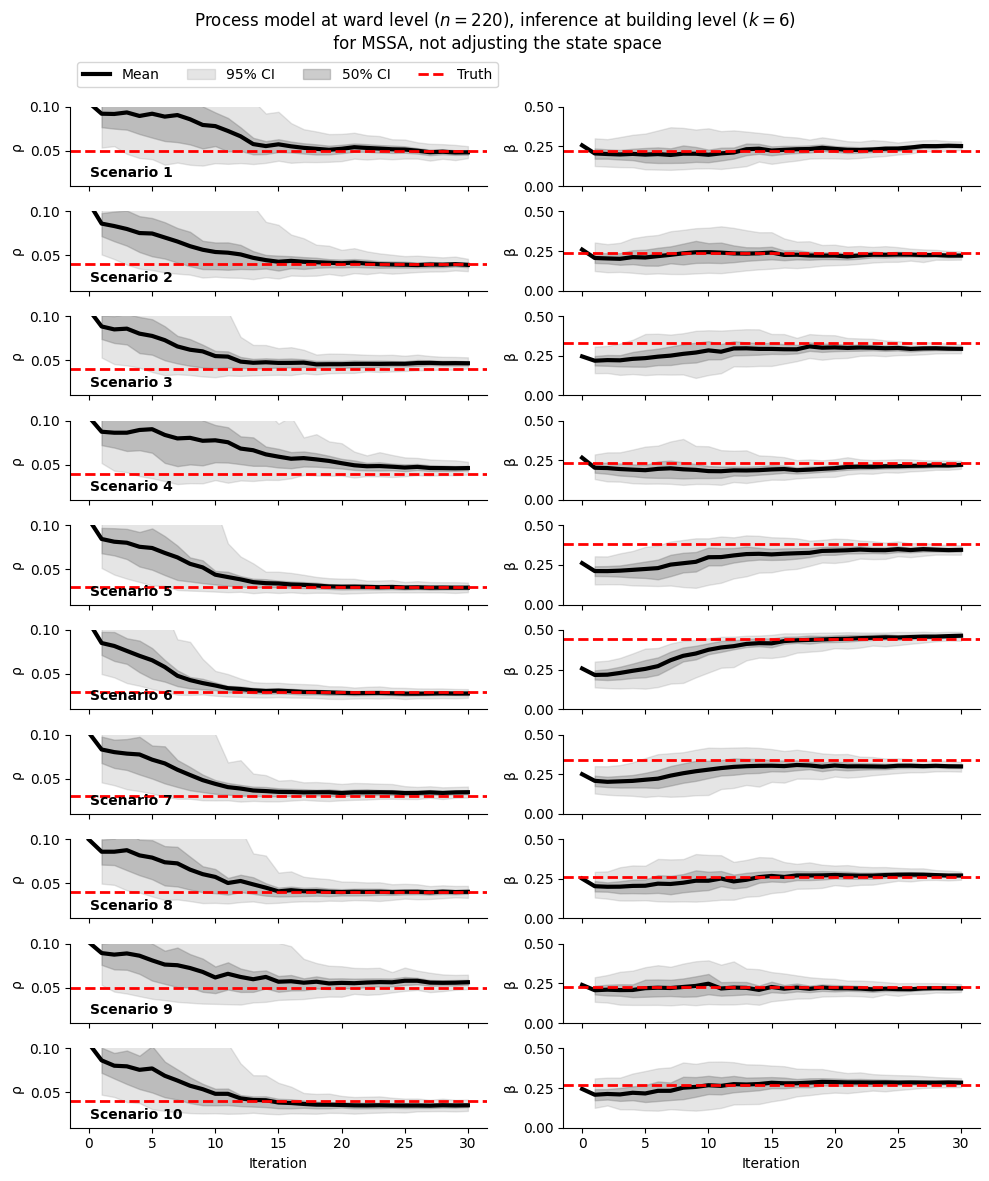

Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


In [35]:
from utils_local.misc import amro2title, amro2cute
import matplotlib.pyplot as plt

from diagnostic_plots import convergence_plot
from utils import create_df_response

for idx_amro, amro in enumerate(amro_search):
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    fig, axes = plt.subplots(len(scenarios_df), 2, figsize=(10, 12), sharex=True, sharey="col")
    for idx_row, row in scenarios_df.iterrows():

        inference = np.load(os.path.join(path_to_save, "no_adjust_state_space",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        x_sim     = inference["state_space"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=Nif)
        β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=Nif)

        p_dfs             = [ρ_df, β_df]
        param_label       = ["ρ", "β"]
        parameters_range  = np.array([[0.01, 10/100], [0, 0.5]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[idx_row, :], fig=fig, param_truth=list(θtruth[:, 0]))
        axes[idx_row, 0].legend().remove(); axes[idx_row, 1].legend().remove()
        axes[idx_row, 1].set_xlabel(None)

        axes[idx_row, 0].spines['right'].set_visible(False)
        axes[idx_row, 0].spines['top'].set_visible(False)

        axes[idx_row, 1].spines['right'].set_visible(False)
        axes[idx_row, 1].spines['top'].set_visible(False)
        axes[idx_row, 0].text(x=0.1, y=0.02, s=f"Scenario {idx_row+1}", weight='bold')

    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.65), ncol=4)
    axes[idx_row, 0].set_xlabel("Iteration")
    axes[idx_row, 1].set_xlabel("Iteration")

    fig.suptitle(f"Process model at ward level ($n=220$), inference at building level ($k=6$)\n for {amro2title(amro)}, not adjusting the state space", x=0.5)
    plt.tight_layout()
    fig.savefig(os.path.join(path_to_save, "no_adjust_state_space", "convergence_plot_all.png"), dpi=300, bbox_inches="tight")

    if amro2title(amro) == "MSSA":
        plt.show()
    else:
        plt.close()

In [38]:
θtruth.shape

(2, 300)

In [39]:
import seaborn as sns
for idx_amro, amro in enumerate(amro_search):

    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    fig, axes = plt.subplots(2, 5, figsize=(10, 12), sharex=False, sharey=False)
    for idx_row, row in scenarios_df.iterrows():
        inference = np.load(os.path.join(path_to_save, "adjust_state_space",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        x_sim     = inference["state_space"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        sns.kdeplot(ax    = axes.flatten()[idx_row],
                        x     = np.squeeze(θpost[0, :, :, [-1]].mean(-2)),
                        y     = np.squeeze(θpost[1, :, :, [-1]].mean(-2)),
                        cmap  = "Reds",
                        fill = True,  thresh=0)
        axes.flatten().scatter(x=θtruth[0, 0], y=θtruth[1, 0], color="red", marker="x", s=50)
        axes.flatten()[idx_row]
        axes.flatten()[idx_row]
        axes.flatten()[idx_row].set_title(f"Scenario {idx_row+1}")


# Inferences adjusting the state space

the problem is that pompjax asssume the state space is a vector $x\in R^{n \times m}$, and we putted the number of populations of the meta in the second axis such that $x\in R^{3 \times p \times m }$, and $n=3 \times p$. $p:=$ number of populations.

So we need to change the process model to handle this, I think it could be done easily just adding a np.reshape(-1, m), but we'll see...

In [ ]:
from models import binomial_transition, poisson_transition, check_state_space

def process_metapop2(t, x, gamma, beta, delta, Nmean, N, A, D, M, model_settings=None):
    """ Susceptible - Colonized meta-population model

    Args:
        x[t]  : state space
        gamma : importation rate
        beta  : transmission rate
        delta : decolonization rate
        A     : Admitted
        D     : Discharged
        M     : Movements matrix

    Returns:
        x[t+1]: State space in t+1.
    """

    n       = model_settings["n"]
    num_pop = model_settings["num_pop"]
    m       = model_settings["m"]

    x = np.reshape(x, (int(n/num_pop), num_pop, m))
    C = x[0, :, :]
    S = np.clip(N - C, 0, N)

    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.clip(np.nan_to_num(C/N), 0, 1)

    λ = beta * C / Nmean # force of infection

    # moving out and in colonized
    Cout  = binomial_transition(list(np.sum(M, axis=1, keepdims=True)), c)
    Cin   = M.T @ c

    a2c  = binomial_transition(list(A), gamma) # people admitted colonized.
    c2d  = binomial_transition(list(D), c)     # discharged colonized

    s2c  = poisson_transition(S, λ)     # new colonized
    c2s  = poisson_transition(C, delta) # decolonizations

    C    = C + a2c - c2d + s2c - c2s + Cin - Cout
    C    = np.clip(C, 0, N)
    x    = check_state_space(np.array([C, a2c, s2c]))

    return np.reshape(x, (n, m))

def init_metapop2(N0, c0, model_settings):
    """ Initial conditions model.
        Args:
            N0 (int):    Initial size of populations.
            c0 (int):    Initial fraction of carriers.
        Returns:
            x0 (np.array): Initial conditions of the state space.
    """
    m       = model_settings["m"]
    num_pop = model_settings["num_pop"]
    n       = model_settings["n"]

    N0   = np.expand_dims(N0, -1) * np.ones((num_pop, m))
    C0   = c0 * N0
    AC   = np.zeros((num_pop, m))
    newC = np.zeros((num_pop, m))
    x    = np.array([C0, AC, newC])
    return np.reshape(x, (n, m))

def observe_metapop2(t, x, N, rho, num_tests, model_settings, ward2cluster=None):
    """ Observational model
        Args:
            t (int):      Time
            x (np.array): State space
            rho (float):  Observation probability
        Returns:
            y (np.array): Observed carriers ~ Binomial(C, rho)
    """

    n       = model_settings["n"]
    m       = model_settings["m"]
    num_pop = model_settings["num_pop"]
    k       = model_settings["k"]

    x       = np.reshape(x, (int(n/num_pop), num_pop, m))
    C       = x[0, :, :]

    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.clip(np.nan_to_num(C/N), 0, 1)

    observed_colonized = np.random.binomial(list(num_tests * np.ones((num_pop, m))), rho * c)
    # need to resample this to [num_buildings x m] (maybe using the same buildings that rami used)
    obs_col_building = np.zeros((k, m))

    for i in range(num_pop):
        obs_col_building[ward2cluster[i], :] += observed_colonized[i, :]

    return obs_col_building


def simulate_metapop2(process_model, observational_model, init_state, θsim, model_settings):
    """ Simulate model with initial conditions and parameters
        x \in R^{n/num_pop x num_pop x ms}

    Args:
        model (function):        Process model
        observe (function):      Observational model
        initial_x0 (function):   Initial condition guess model.
        θ_sim (np.array):        Parameters
    """
    n = model_settings["n"]
    k = model_settings["k"]
    m = model_settings["m"]
    T = model_settings["T"]

    x_sim = np.full((T, n, m), np.nan)
    y_sim = np.full((T, k, m), np.nan)

    x0 = init_state(θsim)


    x_sim[0, :, :] = x0
    y_sim[0, :, :] = observational_model(0, x0, θsim)

    for t in range(1, T):
        x_sim[t, :, :] = process_model(t, x_sim[t-1, :, :], θsim)
        y_sim[t, :, :] = observational_model(t, x_sim[t, :, :], θsim)

    return x_sim, y_sim

In [ ]:
from utils_local.misc import amro2title

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

model_settings = {
    "param_name"  : ["ρ", "β"],       # importation and transmission rate
    "p"           : 2,                # number of parameters
    "dt"          : 1,                # time step
    "m"           : 300,              # number of ensembles
    "stochastic"  : True              # is stochastic
    }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
num_pop          = num_wards

model_settings["n"]           = 3 * num_pop            # number of state variables / dimension of the state space
model_settings["T"]           = len(dates_simulation)  # time to run
model_settings["num_pop"]     = num_pop
model_settings["dates"]       = dates_simulation
model_settings["num_build"]   = len(np.unique(list(wardid2buildingid.values())))
model_settings["k"]           = model_settings["num_build"] # observing at the building aggregation

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_row, row in scenarios_df.iterrows():
        print(f"\t Synthetic {idx_row+1}/{len(scenarios_df)}")

        model_settings["param_truth"]     = [row["rho"], row["beta"]]
        if_settings["adjust_state_space"] = True

        path_to_samples = os.path.join(path_to_save, "adjust_state_space", f"scenario{idx_row+1}")
        os.makedirs(path_to_samples, exist_ok=True)

        if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
            continue

        init_state  = lambda θ:  init_metapop2(
                                                N0             = H[:, 0],
                                                c0             = gamma, # importation rate
                                                model_settings = model_settings)

        process  = lambda t, x, θ : process_metapop2(t, x,
                                                    gamma = gamma * np.ones(model_settings["m"]),
                                                    beta  = θ[1, :],
                                                    delta = delta,
                                                    Nmean = np.expand_dims(Hmean_df, -1),
                                                    N     = H[:, [t]],
                                                    A     = A[:, [t]],
                                                    D     = D[:, [t]],
                                                    M     = M[:, :, t],
                                                    model_settings=model_settings)

        obs_model = lambda t, x, θ: observe_metapop2(t, x,
                                                rho            = θ[0, :],
                                                N              = H[:, [t]],
                                                num_tests      = tests[:, [t]],
                                                model_settings = model_settings,
                                                ward2cluster   = wardid2buildingid)

        run_amro_synthetic(f               = process,
                            f0             = init_state,
                            g              = obs_model,
                            fsim           = simulate_metapop2,
                            model_settings = model_settings,
                            if_settings    = if_settings,
                            id_run         = id_run,
                            path_to_save   = path_to_samples
                            )
    plt.close()


In [ ]:
from utils_local.misc import amro2title, amro2cute
import matplotlib.pyplot as plt

from diagnostic_plots import convergence_plot
from utils import create_df_response

for idx_amro, amro in enumerate(amro_search):

    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    fig, axes = plt.subplots(len(scenarios_df), 2, figsize=(10, 12), sharex=True, sharey="col")
    for idx_row, row in scenarios_df.iterrows():

        inference = np.load(os.path.join(path_to_save, "adjust_state_space",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        x_sim     = inference["state_space"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=Nif)
        β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=Nif)

        p_dfs             = [ρ_df, β_df]
        param_label       = ["ρ", "β"]
        parameters_range  = np.array([[0.01, 10/100], [0, 0.5]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[idx_row, :], fig=fig, param_truth=list(θtruth[:, 0]))
        axes[idx_row, 0].legend().remove(); axes[idx_row, 1].legend().remove()
        axes[idx_row, 1].set_xlabel(None)

        axes[idx_row, 0].spines['right'].set_visible(False)
        axes[idx_row, 0].spines['top'].set_visible(False)

        axes[idx_row, 1].spines['right'].set_visible(False)
        axes[idx_row, 1].spines['top'].set_visible(False)
        axes[idx_row, 0].text(x=0.1, y=0.02, s=f"Scenario {idx_row+1}", weight='bold')

    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.65), ncol=4)
    axes[idx_row, 0].set_xlabel("Iteration")
    axes[idx_row, 1].set_xlabel("Iteration")

    fig.suptitle(f"Process model at ward level ($n=220$), inference at building level ($k=6$)\n for {amro2title(amro)}, adjusting the state space", x=0.5)
    plt.tight_layout()
    fig.savefig(os.path.join(path_to_save, "adjust_state_space", "convergence_plot_all.png"), dpi=300, bbox_inches="tight")
    if amro2title(amro) == "MSSA":
        plt.show()
    else:
        plt.close()


In [ ]:
import seaborn as sns
for idx_amro, amro in enumerate(amro_search):

    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "metapopulation", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    fig, axes = plt.subplots(len(scenarios_df), 2, figsize=(10, 12), sharex=True, sharey="col")
    for idx_row, row in scenarios_df.iterrows():
        inference = np.load(os.path.join(path_to_save, "adjust_state_space",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        x_sim     = inference["state_space"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        sns.kdeplot(ax    = axes.flatten()[idx_row],
                        x     = np.squeeze(θpost[0, :, :, [-1]].mean(-2)),
                        y     = np.squeeze(θpost[1, :, :, [-1]].mean(-2)),
                        cmap  = "Reds",
                        fill = True,  thresh=0)

        axes.flatten()[idx_row]
        axes.flatten()[idx_row]
        axes.flatten()[idx_row].set_title(f"{amro2title(amro_search[idx_amro])}", weight='bold')
